In [1]:
import torch
from torch import nn
import cooler
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import os
import argparse
import pathlib
import h5py
import sys
import pandas as pd
import warnings
import time
from torchvision.transforms import GaussianBlur
import random
import matplotlib.pyplot as plt
import torch.optim as optim
import math
import io
import matplotlib.colors as clr
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
import torchvision.transforms as T
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from HICT_Patterns.hict.patterns.help_functions import get_chromosome_coords, get_genome_coords
from HICT_Patterns.hict.patterns.models import DetectModel, ClassificationModel


In [2]:
local_path = 'D:/Study/HICT/HICT_Patterns/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 512
warnings.filterwarnings('ignore')
device

'cuda'

## Patches dataset

In [15]:
def calculate_diag_means(matrix: np.ndarray, res = 'exp/obs') -> np.ndarray:
        result = np.zeros_like(matrix, dtype='float64')
        expected = np.zeros_like(matrix, dtype='float64')
        assert (
            matrix.shape[0] == matrix.shape[1]
        ), "Matrix must be square"

        n = matrix.shape[0]
        if torch.cuda.is_available():
            expected = sum(
            (
                torch.diag(
                    torch.full((n-abs(i), ), torch.nanmean(torch.tensor(matrix.diagonal(offset=i), device='cuda', dtype=torch.float))), diagonal=i
                ) for i in range(1-n, n)
            )
        )
        else:
            expected = sum(
                (
                    np.diag(
                        [np.nanmean(matrix.diagonal(offset=i))] * (n-abs(i)), k=i
                    ) for i in range(1-n, n)
                )
            )

        if res == 'exp/obs':
            return expected/matrix

        if res == 'exp':
            return expected

        if res == 'exp-obs':
            return expected - matrix

        if res == 'obs-exp':
            return matrix - expected

        if res == 'obs/exp':
            return matrix/expected

        return result

clr_map = clr.LinearSegmentedColormap.from_list('yarg', ['#e6e6e6', '#000'], N=256)

class TrainDatasetPatches(Dataset):
    def __init__(self, cooler_path_list, trans_csv_path_list, resolution, image_size, clean_cooler,detection=True, blur=True, use_means = False):
        sv_count = 0
        self.label_to_index = {'++':torch.tensor([0.0, 0.0, 0.0, 0.0, 1.0]),
                               '+-':torch.tensor([0.0, 0.0, 0.0, 1.0, 0.0]),
                               '-+':torch.tensor([0.0, 0.0, 1.0, 0.0, 0.0]),
                               '--':torch.tensor([0.0, 1.0, 0.0, 0.0, 0.0]),
                               'negative':torch.tensor([1.0, 0.0, 0.0, 0.0,  0.0])}
        self.resolution = resolution
        self.image_size = image_size
        self.detection = detection
        if blur:
            self.blur = GaussianBlur(kernel_size=3, sigma=1)
        self.use_blur = blur
        self.clean_cooler = cooler.Cooler(f'{clean_cooler}::/resolutions/{resolution}')
        self.clean_cooler_matrixes = {}
        for chr in self.clean_cooler.chromnames:
            if use_means:
                self.clean_cooler_matrixes[chr] = calculate_diag_means(self.clean_cooler.matrix(balance=False).fetch(chr))
            else:
                self.clean_cooler_matrixes[chr] = self.clean_cooler.matrix(balance=False).fetch(chr)
        print('Loaded clean cooler')
        indexes = {'file_index':[], 'in_index':[], 'is_sv':[]}
        self.coolers_list = []
        self.matrixes_list = []
        self.sv_files_list = []
        for trans_csv_path, cooler_path, index in tqdm(zip(trans_csv_path_list, cooler_path_list, range(len(trans_csv_path_list)))):
            sv_file = pd.read_csv(trans_csv_path)
            
            sv_count+=sv_file.shape[0]
            c = cooler.Cooler(f'{cooler_path}::/resolutions/{resolution}')
            self.coolers_list.append(c)
            matrixes_by_chr = {}
            for chr in c.chromnames:
                if use_means:
                    matrixes_by_chr[chr] = calculate_diag_means(c.matrix(balance=False).fetch(chr))
                else:
                    matrixes_by_chr[chr] = c.matrix(balance=False).fetch(chr)
            self.matrixes_list.append(matrixes_by_chr)
            neg_sv = {'chr':[], 'label':[], 'start':[], 'end':[]}
            for i, sv in sv_file.iterrows():
                indexes['file_index'].append(index)
                indexes['in_index'].append(i)
                indexes['is_sv'].append(True)
                
                chr_index = random.randint(0, 3)
                chr_size = np.sum(self.clean_cooler.chromsizes[chr_index])
                x = random.randint(image_size//2*resolution, chr_size - image_size//2*resolution-1)
                #y = random.randint(image_size//2*resolution, chr_size - image_size//2*resolution-1)
                y =  random.randint(image_size*resolution, 10*image_size*resolution)
                neg_sv['chr'].append(self.clean_cooler.chromnames[chr_index])
                neg_sv['label'].append('negative')
                neg_sv['start'].append(x)
                neg_sv['end'].append(x+y)

                indexes['file_index'].append(index)
                indexes['in_index'].append(sv_file.shape[0]+i)
                indexes['is_sv'].append(False)
            sv_file = pd.concat([sv_file, pd.DataFrame(neg_sv)])
            self.sv_files_list.append(sv_file)
        if detection:
            self.num_classes = 2
        else:     
            self.num_classes = len(self.sv_files_list[0].label.unique()) + 1
        self.indexes = pd.DataFrame(indexes)

    def __len__(self):
        return self.indexes.shape[0]

    def __getitem__(self, idx):
        row = self.indexes.iloc[idx]
        sv_info = self.sv_files_list[row.file_index].iloc[row.in_index]
        if row.is_sv:
            c = self.coolers_list[row.file_index]
            matrix_full = self.matrixes_list[row.file_index][sv_info.chr]
        else:
            c = self.clean_cooler
            matrix_full = self.clean_cooler_matrixes[sv_info.chr]
        chr_margin = 0
        if row.is_sv:
            for t_chr in c.chromnames:
                if t_chr!=sv_info.chr:
                    chr_margin+=c.chromsizes[t_chr]
                else:
                    break
        x = (sv_info.start)//self.resolution
        y = (sv_info.end)//self.resolution
        pad = self.image_size//2
        #if row.is_sv.iloc[0]:
        #    x += random.randint(-pad//2, pad//2)
        #    y += random.randint(-pad//2, pad//2)
        if x-pad < 0 or y - pad < 0:
            mv = max(-(x-pad), -(y-pad))
            x+=mv
            y+=mv
        if x+pad > matrix_full.shape[0] or y + pad > matrix_full.shape[0]:
            x = min(x,  matrix_full.shape[0]-pad-1)
            y = min(y,  matrix_full.shape[0]-pad-1)

        mat = matrix_full[x-pad:x+pad, y-pad:y+pad]
        mat = np.log10(mat)
        #max_value = np.nanmax(mat)
        #min_value = np.nanmin(mat)
        #mat = calculate_diag_means(mat, 'obs-exp')
        mat = np.nan_to_num(mat, neginf=0, posinf=0)
        #buf = io.BytesIO()
        #plt.imsave(buf,
        #    mat, cmap=clr_map, vmax=max_value, vmin=min_value)
        #img = Image.open(buf)
        try:
            #tens = pil_to_tensor(img).to(device=device, dtype=torch.float)
            tens = torch.from_numpy(mat).reshape((1, self.image_size, self.image_size)).to(device=device, dtype=torch.float)
        except RuntimeError:
            print(matrix_full.shape)
            print(x)
            print(y)
            print(sv_info.chr.iloc[0])
            print(row.is_sv)
        if self.use_blur:
            tens = self.blur(tens)
        #tens = torch.nn.functional.normalize(tens)
        if self.detection:
            return tens, 1 if row.is_sv else 0
        else:
            return tens, self.label_to_index[sv_info.label]

In [9]:
class TrainDatasetDiagonal(Dataset):
    def __init__(self, cooler_path_list, trans_csv_path_list, resolution, image_size, clean_cooler,detection=True):
        sv_count = 0
        self.resolution = resolution
        self.image_size = image_size
        self.detection = detection
        self.blur = GaussianBlur(kernel_size=3, sigma=1)
        self.clean_cooler = cooler.Cooler(f'{clean_cooler}::/resolutions/{resolution}')
        indexes = {'file_index':[], 'in_index':[], 'is_sv':[]}
        self.coolers_list = []
        self.sv_files_list = []
        for trans_csv_path, cooler_path, index in zip(trans_csv_path_list, cooler_path_list, range(len(trans_csv_path_list))):
            sv_file = pd.read_csv(trans_csv_path)
            
            sv_count+=sv_file.shape[0]
            c = cooler.Cooler(f'{cooler_path}::/resolutions/{resolution}')
            self.coolers_list.append(c)
            neg_sv = {'chr':[], 'label':[], 'start':[], 'end':[]}
            for i, sv in sv_file.iterrows():
                indexes['file_index'].append(index)
                indexes['in_index'].append(i)
                indexes['is_sv'].append(True)
                
                chr_size = np.sum(self.clean_cooler.chromsizes.values)
                neg_sv['chr'].append(sv.chr)
                neg_sv['label'].append('0')
                x = random.randint(image_size//2*resolution, chr_size - image_size//2*resolution)
                y = random.randint(image_size//2*resolution, chr_size - image_size//2*resolution)
                neg_sv['start'].append(x)
                neg_sv['end'].append(y)

                indexes['file_index'].append(index)
                indexes['in_index'].append(sv_file.shape[0]+i)
                indexes['is_sv'].append(False)
            sv_file = pd.concat([sv_file, pd.DataFrame(neg_sv)])
            self.sv_files_list.append(sv_file)
        if detection:
            self.num_classes = 2
        else:     
            self.num_classes = len(self.sv_files_list[0].label.unique()) + 1
        self.indexes = pd.DataFrame(indexes)

    def __len__(self):
        return self.indexes.shape[0]*2

    def __getitem__(self, idx_double):
        idx = idx_double//2
        row = self.indexes.iloc[[idx]]
        if row.is_sv.iloc[0]:
            c = self.coolers_list[row.file_index.iloc[0]]
        else:
            c = self.clean_cooler
        sv_info = self.sv_files_list[row.file_index.iloc[0]]
        try:
            sv_info = sv_info.iloc[[row.in_index.iloc[0]]]
        except IndexError:
            print(row.in_index.iloc[0])
            print(sv_info)
            k = 1 /0
        chr_margin = 0
        if row.is_sv.iloc[0]:
            for t_chr in c.chromnames:
                if t_chr!=sv_info.chr.iloc[0]:
                    chr_margin+=c.chromsizes[t_chr]
                else:
                    break
        if idx_double % 2 == 0:
            x = (chr_margin+sv_info.start.iloc[0])//self.resolution
            y = (chr_margin+sv_info.start.iloc[0])//self.resolution
        else:
            x = (chr_margin+sv_info.end.iloc[0])//self.resolution
            y = (chr_margin+sv_info.end.iloc[0])//self.resolution
        pad = self.image_size//2
        if row.is_sv.iloc[0]:
            mv_r = random.randint(-pad//4, pad//4)
            x += mv_r
            y += mv_r
        if x-pad < 0 or y - pad < 0:
            mv = max(-(x-pad), -(y-pad))
            x+=mv
            y+=mv

        try:
            mat = c.matrix(balance=False)[x-pad:x+pad, y-pad:y+pad]
        except ValueError:
            mat_size = sum(c.chromsizes)//self.resolution
            if x+pad > mat_size or y + pad > mat_size:
                mv = x+pad-mat_size
                x-=mv
                y-=mv
            mat = c.matrix(balance=False)[x-pad:x+pad, y-pad:y+pad]
        mat = np.log10(mat)
        mat = np.nan_to_num(mat, neginf=0, posinf=0)
        tens = torch.from_numpy(mat).reshape((1, self.image_size, self.image_size)).to(device=device, dtype=torch.float)
        tens = self.blur(tens)
        if self.detection:
            return tens,  float(1) if row.is_sv.iloc[0] else float(0)
        else:
            return tens, sv_info.label.iloc[0]

In [4]:
train_coolers = []
train_csvs = []
test_coolers = []
test_csvs = []
for prefix_cool, prefix_csv in zip(
            ( '_long_',  '2_long_'),
            ('_long', '_long')):
    train_coolers.append(f'{local_path}data/ZANU/ZANU{prefix_cool}4DN.mcool')
    train_csvs.append(f'{local_path}data/ZANU/transitions{prefix_csv}.csv',)

for prefix_cool, prefix_csv in zip(
            #('_short_', '_short_2_', '_medium_', '_long_', '2_short_', '2_short_2_', '2_medium_', '2_long_'),
            #('_short', '_short_2', '_medium', '_long', '_short', '_short_2', '_medium', '_long')):
            ('_medium_', '_long_',  '2_medium_', '2_long_'),
            ( '_medium', '_long',  '_medium', '_long')):
    train_coolers.append(f'{local_path}data/arab/ARAB{prefix_cool}4DN.mcool')
    train_csvs.append(f'{local_path}data/arab/transitions{prefix_csv}.csv',)
    
for prefix_cool, prefix_csv in zip(
            ('_short_', '2_short_', '2_short_2_' ),
            ('_short', '_short', '_short_2')):
    test_coolers.append(f'{local_path}data/ZANU/ZANU{prefix_cool}4DN.mcool')
    test_csvs.append(f'{local_path}data/ZANU/transitions{prefix_csv}.csv',)

In [5]:
from sklearn import metrics

def run_epoch(model, phase, dataloader):
  if phase == 'train':
      model.train()
  else:
      model.eval()

  running_loss = 0.0
  running_corrects = 0
  y_test = []
  y_pred = []
  all_elems_count = 0
  cur_tqdm = tqdm(dataloader)
  for inputs, labels in cur_tqdm:
    bz = inputs.shape[0]
    all_elems_count += bz
    
    inputs = inputs.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True, dtype=torch.float)

    outputs = model(inputs)
    outputs = outputs.resize(outputs.shape[0])
    loss = criterion(outputs, labels)
    if phase == 'train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    preds = torch.round(outputs)
    y_test.extend(labels.detach().cpu().numpy())
    y_pred.extend(preds.detach().cpu().numpy())
    running_loss += loss.item() * bz
    corrects_cnt = torch.sum(preds == labels.detach())
    running_corrects += corrects_cnt
    show_dict = {'Loss': f'{loss.item():.6f}',
                'Corrects': f'{corrects_cnt.item()}/{bz}',
                'Accuracy': f'{(corrects_cnt * 100 / bz).item():.3f}%'}
    cur_tqdm.set_postfix(show_dict)

  conf_matrix = metrics.confusion_matrix(y_test, y_pred)

  print("Calculating metrics...")
  f05_macro = metrics.fbeta_score(y_test, y_pred, average="macro", beta=0.5)
  f1_macro = metrics.f1_score(y_test, y_pred, average="macro")
  epoch_loss = running_loss / all_elems_count
  epoch_acc = running_corrects.float().item() / all_elems_count
  return epoch_loss, epoch_acc, f05_macro, f1_macro, conf_matrix

def test_epoch(model, dataloader):
    with torch.inference_mode():
      return run_epoch(model,'test', dataloader)

def train_epoch(model, dataloader):
    return run_epoch(model, 'train', dataloader)

In [6]:
import time
import math
import matplotlib.pyplot as plt
import os

log_folder = 'logs'
os.makedirs(log_folder, exist_ok=True)

def train_model(dataloaders, model, num_epochs=20):
  print(f"Training model with params:")
  print(f"Optim: {optimizer}")
  print(f"Criterion: {criterion}")

  phases = ['train']
  for phase in dataloaders:
      if phase not in phases:
          phases.append(phase)

  saved_epoch_losses = {phase: [] for phase in phases}
  saved_epoch_accuracies = {phase: [] for phase in phases}
  saved_epoch_f1_macros = {phase: [] for phase in phases}

  for epoch in range(1, num_epochs + 1):
      start_time = time.time()

      print("=" * 100)
      print(f'Epoch {epoch}/{num_epochs}')
      print('-' * 10)

      for phase in phases:
          print("--- Cur phase:", phase)
          epoch_loss, epoch_acc, f05_macro, f1_macro, conf_matrix = \
              train_epoch(model, dataloaders[phase]) if phase == 'train' \
                  else test_epoch(model, dataloaders[phase])
          saved_epoch_losses[phase].append(epoch_loss)
          saved_epoch_accuracies[phase].append(epoch_acc)
          saved_epoch_f1_macros[phase].append(f1_macro)
          print(f'{phase} loss: {epoch_loss:.6f}, '
                f'acc: {epoch_acc:.6f}, '
                f'f05_macro: {f05_macro:.6f}, '
                f'f1_macro: {f1_macro:.6f}')
          print("Confusion matrix:")
          print(conf_matrix)

      if epoch == num_epochs:
        plt.title(f'Losses during training. Epoch {epoch}/{num_epochs}.')
        plt.plot(range(1, epoch + 1), saved_epoch_losses['train'], label='Train Loss')
        plt.xlabel('Epochs')
        plt.ylabel(criterion.__class__.__name__)
        plt.legend(loc="upper left")
        plt.savefig(f'{log_folder}/loss_graph_epoch{epoch + 1}.png')
        plt.show()
        plt.close('all')

        plt.title(f'Accuracies during training. Epoch {epoch}/{num_epochs}.')
        plt.plot(range(1, epoch + 1), saved_epoch_accuracies['train'], label='Train Acc')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc="upper left")
        plt.savefig(f'{log_folder}/acc_graph_epoch{epoch + 1}.png')
        plt.show()
        plt.close('all')

      end_time = time.time()
      epoch_time = end_time - start_time
      print("-" * 10)
      print(f"Epoch Time: {math.floor(epoch_time // 60)}:{math.floor(epoch_time % 60):02d}")

  print("*** Training Completed ***")

  return saved_epoch_losses, saved_epoch_accuracies, saved_epoch_f1_macros

## Stage 1

In [8]:
train_dataset = TrainDatasetDiagonal(
    cooler_path_list=train_coolers,
    trans_csv_path_list=train_csvs,
    clean_cooler=f'{local_path}data/ZANU/zanu_male_scaffolded_4DN.mcool',
    resolution=50000,
    image_size=48,
    detection=True)

In [9]:
len(train_dataset)

13056

In [ ]:
model = DetectModel(in_channels=1, image_size=48, num_models=3)
model.to(device=device)
learning_rate = 1e-4
criterion = nn.BCELoss ()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = TrainDatasetDiagonal(
    cooler_path_list=train_coolers,
    trans_csv_path_list=train_csvs,
    clean_cooler=f'{local_path}data/ZANU/zanu_male_scaffolded_4DN.mcool',
    resolution=50000,
    image_size=48,
    detection=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

num_epochs = 5
dataloaders = dict()
dataloaders['train'] = train_dataloader
train_model(dataloaders, model, num_epochs)

torch.save(model.state_dict(), f'{local_path}weights/torch_ensemble_50k_48_diag.pt')

In [33]:
torch.save(model.state_dict(), f'{local_path}weights_balanced/torch_ensemble_50k_48_diag.pt')

## Stage 2

Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Criterion: BCELoss()
Epoch 1/5
----------
--- Cur phase: train


100%|██████████| 26/26 [01:33<00:00,  3.60s/it, Loss=0.048571, Corrects=249/256, Accuracy=97.266%]


Calculating metrics...
train loss: 0.149636, acc: 0.923100, f05_macro: 0.923119, f1_macro: 0.923099
Confusion matrix:
[[5994  534]
 [ 470 6058]]
----------
Epoch Time: 1:33
Epoch 2/5
----------
--- Cur phase: train


100%|██████████| 26/26 [01:22<00:00,  3.18s/it, Loss=0.023335, Corrects=253/256, Accuracy=98.828%]


Calculating metrics...
train loss: 0.034200, acc: 0.986366, f05_macro: 0.986370, f1_macro: 0.986366
Confusion matrix:
[[6452   76]
 [ 102 6426]]
----------
Epoch Time: 1:22
Epoch 3/5
----------
--- Cur phase: train


100%|██████████| 26/26 [01:24<00:00,  3.26s/it, Loss=0.033884, Corrects=252/256, Accuracy=98.438%]


Calculating metrics...
train loss: 0.024517, acc: 0.991268, f05_macro: 0.991268, f1_macro: 0.991268
Confusion matrix:
[[6473   55]
 [  59 6469]]
----------
Epoch Time: 1:24
Epoch 4/5
----------
--- Cur phase: train


100%|██████████| 26/26 [01:19<00:00,  3.06s/it, Loss=0.016334, Corrects=255/256, Accuracy=99.609%]


Calculating metrics...
train loss: 0.019559, acc: 0.993107, f05_macro: 0.993108, f1_macro: 0.993107
Confusion matrix:
[[6490   38]
 [  52 6476]]
----------
Epoch Time: 1:19
Epoch 5/5
----------
--- Cur phase: train


100%|██████████| 26/26 [01:16<00:00,  2.93s/it, Loss=0.022072, Corrects=252/256, Accuracy=98.438%]

Calculating metrics...
train loss: 0.016785, acc: 0.993873, f05_macro: 0.993874, f1_macro: 0.993873
Confusion matrix:
[[6480   48]
 [  32 6496]]


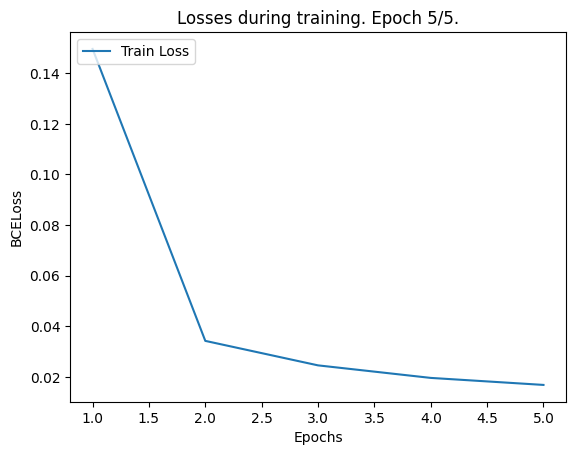

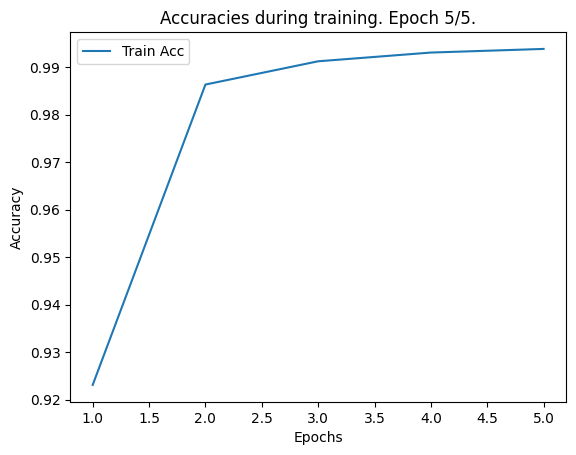

----------
Epoch Time: 1:16
*** Training Completed ***


In [11]:
model = DetectModel(in_channels=1, image_size=48, num_models=10)
model.to(device=device)
learning_rate = 1e-4
criterion = nn.BCELoss ()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = TrainDatasetDiagonal(
    cooler_path_list=train_coolers,
    trans_csv_path_list=train_csvs,
    clean_cooler=f'{local_path}data/ZANU/zanu_male_scaffolded_4DN.mcool',
    resolution=10000,
    image_size=48,
    detection=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

num_epochs = 5
dataloaders = dict()
dataloaders['train'] = train_dataloader
train_model(dataloaders, model, num_epochs)

torch.save(model.state_dict(), f'{local_path}weights/torch_ensemble_10k_48_diag.pt')

## Stage 3

In [16]:
train_dataset = TrainDatasetPatches(
    cooler_path_list=train_coolers,
    trans_csv_path_list=train_csvs,
    clean_cooler=f'{local_path}data/ZANU/zanu_male_scaffolded_4DN.mcool',
    resolution=50000,
    image_size=48,
    detection=True,
    blur=True,
    use_means=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


Loaded clean cooler


6it [01:35, 15.98s/it]


Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Criterion: BCELoss()
Epoch 1/10
----------
--- Cur phase: train


100%|██████████| 4/4 [00:01<00:00,  2.33it/s, Loss=0.312369, Corrects=56/60, Accuracy=93.333%]  


Calculating metrics...
train loss: 0.628495, acc: 0.571429, f05_macro: 0.571207, f1_macro: 0.570738
Confusion matrix:
[[488 310]
 [374 424]]
----------
Epoch Time: 0:01
Epoch 2/10
----------
--- Cur phase: train


100%|██████████| 4/4 [00:01<00:00,  2.38it/s, Loss=0.142314, Corrects=58/60, Accuracy=96.667%]  


Calculating metrics...
train loss: 0.244747, acc: 0.912907, f05_macro: 0.917501, f1_macro: 0.912370
Confusion matrix:
[[666 132]
 [  7 791]]
----------
Epoch Time: 0:01
Epoch 3/10
----------
--- Cur phase: train


100%|██████████| 4/4 [00:01<00:00,  2.64it/s, Loss=0.093636, Corrects=58/60, Accuracy=96.667%]  


Calculating metrics...
train loss: 0.111973, acc: 0.963033, f05_macro: 0.963036, f1_macro: 0.963032
Confusion matrix:
[[770  28]
 [ 31 767]]
----------
Epoch Time: 0:01
Epoch 4/10
----------
--- Cur phase: train


100%|██████████| 4/4 [00:02<00:00,  1.89it/s, Loss=0.103077, Corrects=58/60, Accuracy=96.667%]  


Calculating metrics...
train loss: 0.070796, acc: 0.976190, f05_macro: 0.976213, f1_macro: 0.976190
Confusion matrix:
[[775  23]
 [ 15 783]]
----------
Epoch Time: 0:02
Epoch 5/10
----------
--- Cur phase: train


100%|██████████| 4/4 [00:01<00:00,  2.24it/s, Loss=0.063632, Corrects=59/60, Accuracy=98.333%]  


Calculating metrics...
train loss: 0.069053, acc: 0.976190, f05_macro: 0.976305, f1_macro: 0.976187
Confusion matrix:
[[788  10]
 [ 28 770]]
----------
Epoch Time: 0:01
Epoch 6/10
----------
--- Cur phase: train


100%|██████████| 4/4 [00:01<00:00,  2.50it/s, Loss=0.017489, Corrects=60/60, Accuracy=100.000%] 


Calculating metrics...
train loss: 0.046329, acc: 0.985589, f05_macro: 0.985607, f1_macro: 0.985589
Confusion matrix:
[[783  15]
 [  8 790]]
----------
Epoch Time: 0:01
Epoch 7/10
----------
--- Cur phase: train


100%|██████████| 4/4 [00:01<00:00,  2.59it/s, Loss=0.026251, Corrects=59/60, Accuracy=98.333%]  


Calculating metrics...
train loss: 0.037926, acc: 0.987469, f05_macro: 0.987475, f1_macro: 0.987469
Confusion matrix:
[[786  12]
 [  8 790]]
----------
Epoch Time: 0:01
Epoch 8/10
----------
--- Cur phase: train


100%|██████████| 4/4 [00:01<00:00,  2.67it/s, Loss=0.031737, Corrects=59/60, Accuracy=98.333%]  


Calculating metrics...
train loss: 0.032820, acc: 0.986216, f05_macro: 0.986239, f1_macro: 0.986215
Confusion matrix:
[[783  15]
 [  7 791]]
----------
Epoch Time: 0:01
Epoch 9/10
----------
--- Cur phase: train


100%|██████████| 4/4 [00:01<00:00,  2.70it/s, Loss=0.044063, Corrects=59/60, Accuracy=98.333%]  


Calculating metrics...
train loss: 0.023753, acc: 0.991855, f05_macro: 0.991864, f1_macro: 0.991855
Confusion matrix:
[[794   4]
 [  9 789]]
----------
Epoch Time: 0:01
Epoch 10/10
----------
--- Cur phase: train


100%|██████████| 4/4 [00:01<00:00,  2.55it/s, Loss=0.014996, Corrects=60/60, Accuracy=100.000%] 


Calculating metrics...
train loss: 0.021090, acc: 0.991855, f05_macro: 0.991864, f1_macro: 0.991855
Confusion matrix:
[[789   9]
 [  4 794]]


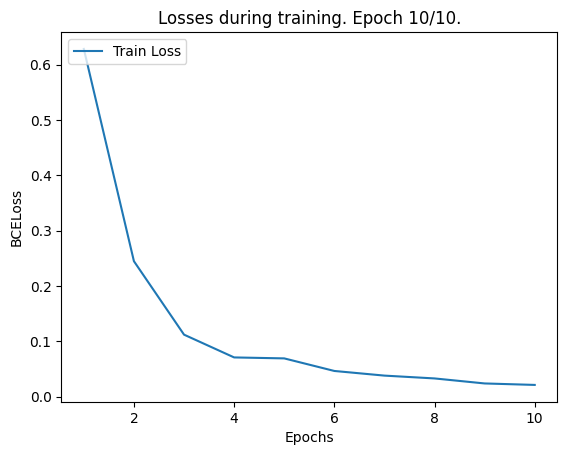

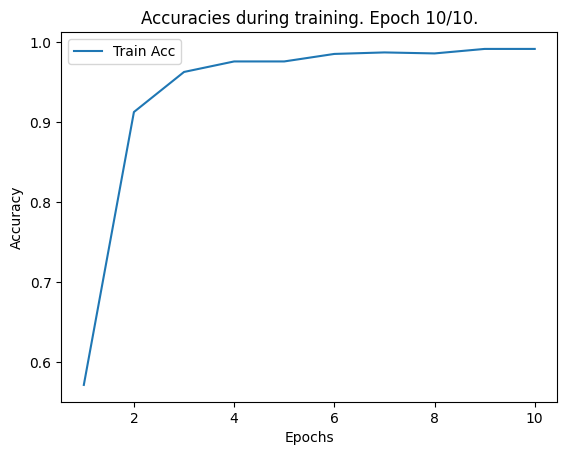

----------
Epoch Time: 0:01
*** Training Completed ***


In [17]:
model = DetectModel(in_channels=1, image_size=48, num_models=10)
model.to(device=device)
learning_rate = 1e-4
criterion = nn.BCELoss ()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 10
dataloaders = dict()
dataloaders['train'] = train_dataloader
train_model(dataloaders, model, num_epochs)

torch.save(model.state_dict(), f'{local_path}weights/torch_ensemble_50k_48_patch.pt')

## Stage 4

Loaded clean cooler


10it [00:25,  2.54s/it]


Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Criterion: BCELoss()
Epoch 1/5
----------
--- Cur phase: train


100%|██████████| 9/9 [00:04<00:00,  1.97it/s, Loss=0.001645, Corrects=44/44, Accuracy=100.000%] 


Calculating metrics...
train loss: 0.160168, acc: 0.968599, f05_macro: 0.968606, f1_macro: 0.968599
Confusion matrix:
[[2011   59]
 [  71 1999]]
----------
Epoch Time: 0:04
Epoch 2/5
----------
--- Cur phase: train


100%|██████████| 9/9 [00:03<00:00,  2.37it/s, Loss=0.000591, Corrects=44/44, Accuracy=100.000%] 


Calculating metrics...
train loss: 0.022949, acc: 0.994686, f05_macro: 0.994690, f1_macro: 0.994686
Confusion matrix:
[[2063    7]
 [  15 2055]]
----------
Epoch Time: 0:03
Epoch 3/5
----------
--- Cur phase: train


100%|██████████| 9/9 [00:03<00:00,  2.30it/s, Loss=0.000637, Corrects=44/44, Accuracy=100.000%] 


Calculating metrics...
train loss: 0.010599, acc: 0.995894, f05_macro: 0.995898, f1_macro: 0.995894
Confusion matrix:
[[2066    4]
 [  13 2057]]
----------
Epoch Time: 0:03
Epoch 4/5
----------
--- Cur phase: train


100%|██████████| 9/9 [00:03<00:00,  2.27it/s, Loss=0.002905, Corrects=44/44, Accuracy=100.000%]  


Calculating metrics...
train loss: 0.004563, acc: 0.998792, f05_macro: 0.998793, f1_macro: 0.998792
Confusion matrix:
[[2069    1]
 [   4 2066]]
----------
Epoch Time: 0:03
Epoch 5/5
----------
--- Cur phase: train


100%|██████████| 9/9 [00:03<00:00,  2.33it/s, Loss=0.000429, Corrects=44/44, Accuracy=100.000%]  


Calculating metrics...
train loss: 0.002556, acc: 0.999275, f05_macro: 0.999275, f1_macro: 0.999275
Confusion matrix:
[[2069    1]
 [   2 2068]]


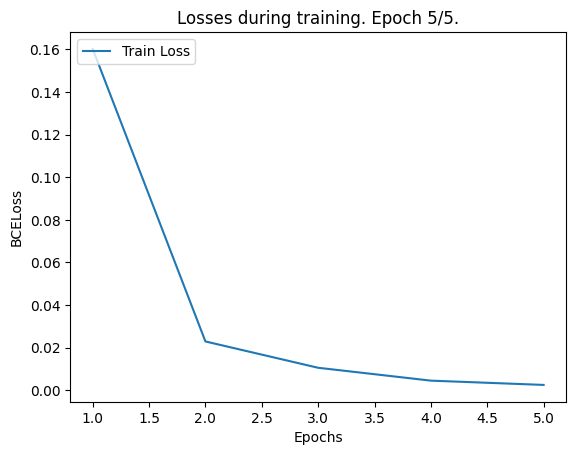

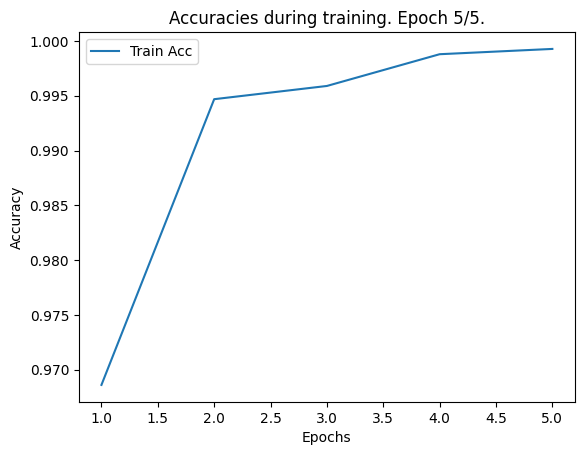

----------
Epoch Time: 0:04
*** Training Completed ***


In [7]:
train_dataset = TrainDatasetPatches(
    cooler_path_list=train_coolers,
    trans_csv_path_list=train_csvs,
    clean_cooler=f'{local_path}data/atrop_ebre/atrop_ebre_4DN.mcool',
    resolution=10000,
    image_size=48,
    blur=True,
    detection=True,
    use_means=False)

model = DetectModel(in_channels=1, image_size=48, num_models=10)
model.to(device=device)
learning_rate = 1e-4
criterion = nn.BCELoss ()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 5
dataloaders = dict()
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloaders['train'] = train_dataloader
train_model(dataloaders, model, num_epochs)

torch.save(model.state_dict(), f'{local_path}weights/torch_ensemble_10k_48_patch.pt')

In [ ]:

num_epochs = 2
dataloaders = dict()
dataloaders['train'] = train_dataloader
train_model(dataloaders, model, num_epochs)

torch.save(model.state_dict(), f'{local_path}weights/torch_ensemble_50k_24_patch_norm.pt')

## 5k_48_clr

In [8]:
model = DetectModel(in_channels=1, image_size=48, num_models=10)
model.to(device=device)
learning_rate = 1e-4
criterion = nn.BCELoss ()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = TrainDatasetPatches(
    cooler_path_list=train_coolers,
    trans_csv_path_list=train_csvs,
    clean_cooler=f'{local_path}data/atrop_ebre/atrop_ebre_4DN.mcool',
    resolution=5000,
    image_size=48,
    blur=True,
    use_means=False,
    detection=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

num_epochs = 5
dataloaders = dict()
dataloaders['train'] = train_dataloader
train_model(dataloaders, model, num_epochs)

torch.save(model.state_dict(), f'{local_path}weights/torch_ensemble_5k_48_clr.pt')

Loaded clean cooler


10it [00:00, 32.45it/s]


Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Criterion: BCELoss()
Epoch 1/5
----------
--- Cur phase: train


  0%|          | 0/9 [00:25<?, ?it/s]


KeyboardInterrupt: 

In [7]:

train_dataset = TrainDatasetPatches(
    cooler_path_list=train_coolers,
    trans_csv_path_list=train_csvs,
    clean_cooler=f'{local_path}data/ZANU/zanu_male_scaffolded_4DN.mcool',
    resolution=10000,
    image_size=48,
    blur=True,
    detection=True)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)


Loaded clean cooler


10it [00:12,  1.29s/it]


tensor([0])


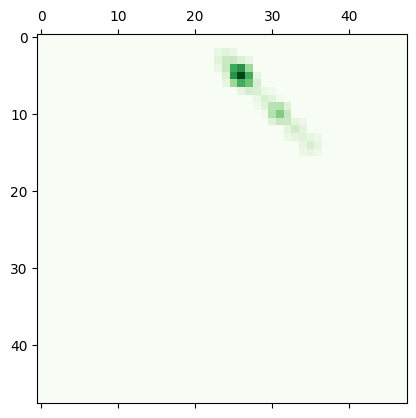

In [14]:

for tens, label in train_dataloader:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #im = ax.matshow(np.log10(calculate_diag_means(mat_balanced)), cmap='Greens')
    print(label)
    mat = tens[0].cpu().numpy()[0]
    im = ax.matshow(mat, cmap='Greens')
    break

In [11]:
model = DetectModel(in_channels=1, image_size=48, num_models=10)
model.to(device=device)
learning_rate = 1e-4
criterion = nn.BCELoss ()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = TrainDatasetPatches(
    cooler_path_list=train_coolers,
    trans_csv_path_list=train_csvs,
    clean_cooler=f'{local_path}data/ZANU/zanu_male_scaffolded_4DN.mcool',
    resolution=10000,
    image_size=48,
    blur=True,
    detection=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

num_epochs = 10
dataloaders = dict()
dataloaders['train'] = train_dataloader
train_model(dataloaders, model, num_epochs)

torch.save(model.state_dict(), f'{local_path}weights/torch_ensemble_10k_48_patch.pt')

KeyboardInterrupt: 

Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Criterion: BCELoss()
Epoch 1/5
----------
--- Cur phase: train


100%|██████████| 13/13 [00:26<00:00,  2.07s/it, Loss=0.155767, Corrects=366/384, Accuracy=95.312%]


Calculating metrics...
train loss: 0.252222, acc: 0.908548, f05_macro: 0.908868, f1_macro: 0.908507
Confusion matrix:
[[2897  367]
 [ 230 3034]]
----------
Epoch Time: 0:26
Epoch 2/5
----------
--- Cur phase: train


100%|██████████| 13/13 [00:26<00:00,  2.05s/it, Loss=0.041690, Corrects=377/384, Accuracy=98.177%]


Calculating metrics...
train loss: 0.084369, acc: 0.976256, f05_macro: 0.976285, f1_macro: 0.976255
Confusion matrix:
[[3205   59]
 [  96 3168]]
----------
Epoch Time: 0:26
Epoch 3/5
----------
--- Cur phase: train


100%|██████████| 13/13 [00:39<00:00,  3.07s/it, Loss=0.037062, Corrects=382/384, Accuracy=99.479%]


Calculating metrics...
train loss: 0.057188, acc: 0.984222, f05_macro: 0.984274, f1_macro: 0.984221
Confusion matrix:
[[3237   27]
 [  76 3188]]
----------
Epoch Time: 0:39
Epoch 4/5
----------
--- Cur phase: train


100%|██████████| 13/13 [00:53<00:00,  4.15s/it, Loss=0.028655, Corrects=382/384, Accuracy=99.479%]


Calculating metrics...
train loss: 0.045607, acc: 0.988205, f05_macro: 0.988257, f1_macro: 0.988204
Confusion matrix:
[[3250   14]
 [  63 3201]]
----------
Epoch Time: 0:54
Epoch 5/5
----------
--- Cur phase: train


100%|██████████| 13/13 [01:16<00:00,  5.92s/it, Loss=0.044512, Corrects=380/384, Accuracy=98.958%]


Calculating metrics...
train loss: 0.040759, acc: 0.989890, f05_macro: 0.989945, f1_macro: 0.989889
Confusion matrix:
[[3256    8]
 [  58 3206]]


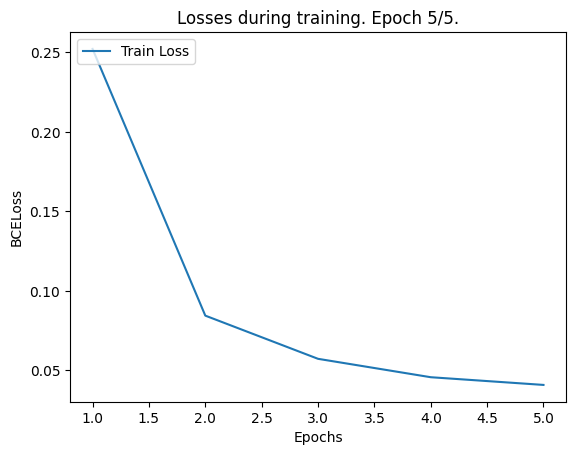

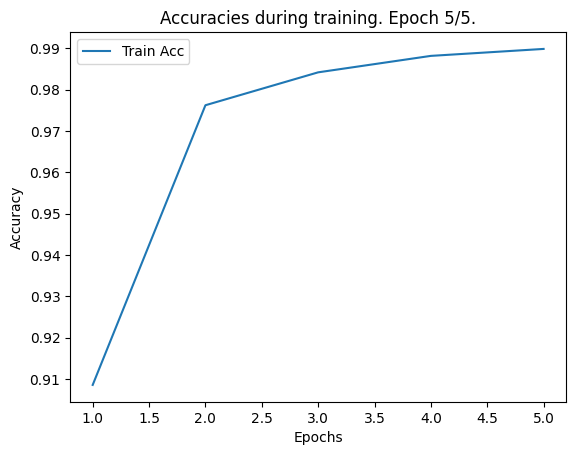

----------
Epoch Time: 1:18
*** Training Completed ***


In [ ]:
model = DetectModel(in_channels=1, image_size=24, num_models=10)
model.to(device=device)
learning_rate = 1e-4
criterion = nn.BCELoss ()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = TrainDatasetPatches(
    cooler_path_list=train_coolers,
    trans_csv_path_list=train_csvs,
    clean_cooler=f'{local_path}data/ZANU/zanu_male_scaffolded_4DN.mcool',
    resolution=5000,
    image_size=24,
    blur=False,
    detection=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

num_epochs = 5
dataloaders = dict()
dataloaders['train'] = train_dataloader
train_model(dataloaders, model, num_epochs)

torch.save(model.state_dict(), f'{local_path}weights/torch_ensemble_5k_24_clr_norm.pt')

## Train classification model

In [4]:
def run_epoch(model, phase, dataloader):
  if phase == 'train':
      model.train()
  else:
      model.eval()

  running_loss = 0.0
  running_corrects = 0
  y_test = []
  y_pred = []
  all_elems_count = 0
  cur_tqdm = tqdm(dataloader)
  for inputs, labels in cur_tqdm:
    bz = inputs.shape[0]
    all_elems_count += bz
    
    inputs = inputs.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True, dtype=torch.float)

    outputs = model(inputs)
    print(outputs)
    loss = criterion(outputs, labels)
    if phase == 'train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    preds = torch.argmax(outputs, dim=1)
    y_test.extend(labels.detach().cpu().numpy())
    y_pred.extend(preds.detach().cpu().numpy())
    running_loss += loss.item() * bz
    corrects_cnt = torch.sum(preds == torch.argmax(labels.detach(), dim=1))
    running_corrects += corrects_cnt
    show_dict = {'Loss': f'{loss.item():.6f}',
                'Corrects': f'{corrects_cnt.item()}/{bz}',
                'Accuracy': f'{(corrects_cnt * 100 / bz).item():.3f}%'}
    cur_tqdm.set_postfix(show_dict)

  print("Calculating metrics...")
  epoch_loss = running_loss / all_elems_count
  epoch_acc = running_corrects.float().item() / all_elems_count
  return epoch_loss, epoch_acc

def test_epoch(model, dataloader):
    with torch.inference_mode():
      return run_epoch(model,'test', dataloader)

def train_epoch(model, dataloader):
    return run_epoch(model, 'train', dataloader)

In [5]:
log_folder = 'logs'
os.makedirs(log_folder, exist_ok=True)

def train_model(dataloaders, model, num_epochs=20):
  print(f"Training model with params:")
  print(f"Optim: {optimizer}")
  print(f"Criterion: {criterion}")

  phases = ['train']
  for phase in dataloaders:
      if phase not in phases:
          phases.append(phase)

  saved_epoch_losses = {phase: [] for phase in phases}
  saved_epoch_accuracies = {phase: [] for phase in phases}

  for epoch in range(1, num_epochs + 1):
      start_time = time.time()

      print("=" * 100)
      print(f'Epoch {epoch}/{num_epochs}')
      print('-' * 10)

      for phase in phases:
          print("--- Cur phase:", phase)
          epoch_loss, epoch_acc = \
              train_epoch(model, dataloaders[phase]) if phase == 'train' \
                  else test_epoch(model, dataloaders[phase])
          saved_epoch_losses[phase].append(epoch_loss)
          saved_epoch_accuracies[phase].append(epoch_acc)
          print(f'{phase} loss: {epoch_loss:.6f}, '
                f'acc: {epoch_acc:.6f}')

      if epoch == num_epochs:
        plt.title(f'Losses during training. Epoch {epoch}/{num_epochs}.')
        plt.plot(range(1, epoch + 1), saved_epoch_losses['train'], label='Train Loss')
        plt.xlabel('Epochs')
        plt.ylabel(criterion.__class__.__name__)
        plt.legend(loc="upper left")
        plt.savefig(f'{log_folder}/loss_graph_epoch{epoch + 1}.png')
        plt.show()
        plt.close('all')

        plt.title(f'Accuracies during training. Epoch {epoch}/{num_epochs}.')
        plt.plot(range(1, epoch + 1), saved_epoch_accuracies['train'], label='Train Acc')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc="upper left")
        plt.savefig(f'{log_folder}/acc_graph_epoch{epoch + 1}.png')
        plt.show()
        plt.close('all')

      end_time = time.time()
      epoch_time = end_time - start_time
      print("-" * 10)
      print(f"Epoch Time: {math.floor(epoch_time // 60)}:{math.floor(epoch_time % 60):02d}")

  print("*** Training Completed ***")

  return saved_epoch_losses, saved_epoch_accuracies

In [7]:
import os

eaglec_answers = os.listdir(f'{local_path}data/eaglec_results/')
for ans_path in eaglec_answers:
    ans = pd.read_csv(f'{local_path}data/eaglec_results/{ans_path}', sep='\t')
    ans['label'] = ans[['++', '+-','-+','--']].idxmax(axis=1)
    ans = ans[ans.chrom1 == ans.chrom2]
    ans.rename(columns={"chrom1": "chr", "pos1": "start", "pos2": "end"}, inplace=True)
    ans = ans[['chr', 'label','start','end']]
    ans.to_csv(f'{local_path}data/eaglec_results/{ans_path.split(".")[0]}.csv', index=False)

In [13]:
train_csvs = []

eaglec_answers = [
 'ARAB_del_4DN.csv',
 'ARAB_long_4DN.csv',
 'dong_colluzzii.csv',
 'gambie_4DN.csv',
 'Mali_Arab_4DN.csv',
 'Mopti_vs_Dong_4DN.csv',
 'ZANU_long_4DN.csv',
 'ARAB_dup_4DN.csv',
 'ZANU_short_4DN.csv']
for ans_path in eaglec_answers:
    train_csvs.append(f'{local_path}data/eaglec_results/{ans_path}')

train_coolers = [f'{local_path}data/arab/Arab_del_4DN.mcool',
                 f'{local_path}data/arab/ARAB_long_4DN.mcool',
                 f'{local_path}data/dong_vs_colluzzi/dong_colluzzii.mcool',
                 f'{local_path}data/gambie/gambie_4DN.mcool',
                 f'{local_path}data/MALI_ARAB/Mali_Arab_4DN.mcool',
                 f'{local_path}data/Mopti_vs_Dong/Mopti_vs_Dong_4DN.mcool',
                 f'{local_path}data/ZANU/ZANU_long_4DN.mcool',
                 f'{local_path}data/arab/Arab_dup_4DN.mcool',
                 f'{local_path}data/ZANU/ZANU_short_4DN.mcool']


train_dataset = TrainDatasetPatches(
    cooler_path_list=train_coolers,
    trans_csv_path_list=train_csvs,
    clean_cooler=f'{local_path}data/ZANU/zanu_male_scaffolded_4DN.mcool',
    resolution=10000,
    image_size=24,
    detection=False,
    use_means=False,
    blur=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


Loaded clean cooler


9it [00:09,  1.10s/it]


tensor([[0., 0., 0., 0., 1.]])


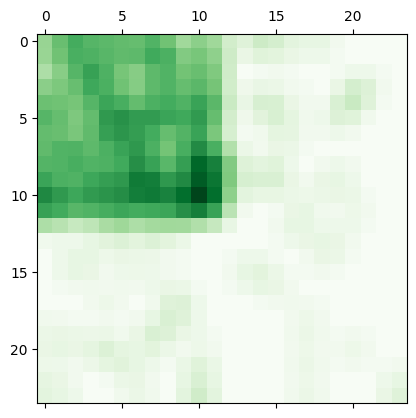

In [20]:

label_to_index = {'++':torch.tensor([0.0, 0.0, 0.0, 0.0, 1.0]),
                               '+-':torch.tensor([0.0, 0.0, 0.0, 1.0, 0.0]),
                               '-+':torch.tensor([0.0, 0.0, 1.0, 0.0, 0.0]),
                               '--':torch.tensor([0.0, 1.0, 0.0, 0.0, 0.0]),
                               'negative':torch.tensor([1.0, 0.0, 0.0, 0.0,  0.0])}
for tens, label in DataLoader(train_dataset, batch_size=1, shuffle=True):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #im = ax.matshow(np.log10(calculate_diag_means(mat_balanced)), cmap='Greens')
    print(label)
    mat = tens[0].cpu().numpy()[0]
    im = ax.matshow(mat, cmap='Greens')
    break

Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Criterion: CrossEntropyLoss()
Epoch 1/10
----------
--- Cur phase: train


  0%|          | 0/3 [00:00<?, ?it/s]

tensor([[0.1718, 0.1914, 0.2176, 0.2127, 0.2066],
        [0.1892, 0.1850, 0.2048, 0.2136, 0.2074],
        [0.1624, 0.2172, 0.1882, 0.2247, 0.2074],
        ...,
        [0.1642, 0.1782, 0.1878, 0.2400, 0.2297],
        [0.1569, 0.2029, 0.1950, 0.2650, 0.1803],
        [0.1696, 0.2188, 0.1884, 0.2147, 0.2085]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 67%|██████▋   | 2/3 [00:01<00:00,  1.62it/s, Loss=1.513109, Corrects=354/512, Accuracy=69.141%]

tensor([[0.3699, 0.1149, 0.2110, 0.1917, 0.1125],
        [0.3249, 0.1522, 0.1703, 0.2032, 0.1494],
        [0.3639, 0.1312, 0.1672, 0.1993, 0.1383],
        ...,
        [0.3563, 0.1290, 0.1740, 0.2197, 0.1209],
        [0.2958, 0.1612, 0.1662, 0.2128, 0.1641],
        [0.3093, 0.1520, 0.1668, 0.2021, 0.1699]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


100%|██████████| 3/3 [00:01<00:00,  1.89it/s, Loss=1.381668, Corrects=241/326, Accuracy=73.926%]


tensor([[0.4515, 0.1032, 0.1390, 0.2033, 0.1030],
        [0.5209, 0.0898, 0.1128, 0.1869, 0.0897],
        [0.5056, 0.1000, 0.1141, 0.2025, 0.0777],
        ...,
        [0.2779, 0.0726, 0.0622, 0.5443, 0.0430],
        [0.3996, 0.0936, 0.0976, 0.3337, 0.0754],
        [0.4656, 0.0851, 0.1896, 0.1851, 0.0746]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Calculating metrics...
train loss: 1.519086, acc: 0.508889
----------
Epoch Time: 0:01
Epoch 2/10
----------
--- Cur phase: train


 33%|███▎      | 1/3 [00:00<00:00,  2.74it/s, Loss=1.322431, Corrects=353/512, Accuracy=68.945%]

tensor([[0.4572, 0.1303, 0.0732, 0.3079, 0.0314],
        [0.6615, 0.0451, 0.1051, 0.1434, 0.0449],
        [0.5820, 0.0665, 0.0942, 0.1816, 0.0758],
        ...,
        [0.6790, 0.0525, 0.0781, 0.1328, 0.0576],
        [0.6443, 0.0609, 0.0880, 0.1468, 0.0600],
        [0.8786, 0.0130, 0.0260, 0.0682, 0.0141]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 67%|██████▋   | 2/3 [00:00<00:00,  2.77it/s, Loss=1.256771, Corrects=355/512, Accuracy=69.336%]

tensor([[0.6360, 0.0471, 0.1035, 0.1720, 0.0414],
        [0.5610, 0.0638, 0.0909, 0.2168, 0.0675],
        [0.8400, 0.0203, 0.0457, 0.0760, 0.0181],
        ...,
        [0.8716, 0.0184, 0.0317, 0.0667, 0.0115],
        [0.0472, 0.0146, 0.0046, 0.9302, 0.0033],
        [0.5206, 0.0254, 0.0415, 0.3736, 0.0390]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


100%|██████████| 3/3 [00:01<00:00,  2.95it/s, Loss=1.175072, Corrects=244/326, Accuracy=74.847%]


tensor([[0.0769, 0.0070, 0.0058, 0.9062, 0.0041],
        [0.8961, 0.0141, 0.0268, 0.0516, 0.0114],
        [0.8874, 0.0149, 0.0394, 0.0427, 0.0156],
        ...,
        [0.6171, 0.1056, 0.0499, 0.2084, 0.0190],
        [0.8610, 0.0196, 0.0331, 0.0668, 0.0194],
        [0.4663, 0.1311, 0.0543, 0.3404, 0.0080]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Calculating metrics...
train loss: 1.261944, acc: 0.705185
----------
Epoch Time: 0:01
Epoch 3/10
----------
--- Cur phase: train


 33%|███▎      | 1/3 [00:00<00:00,  2.84it/s, Loss=1.170039, Corrects=374/512, Accuracy=73.047%]

tensor([[0.9714, 0.0038, 0.0072, 0.0144, 0.0033],
        [0.9801, 0.0028, 0.0070, 0.0081, 0.0019],
        [0.9826, 0.0014, 0.0064, 0.0081, 0.0015],
        ...,
        [0.9209, 0.0076, 0.0155, 0.0472, 0.0087],
        [0.9543, 0.0041, 0.0266, 0.0109, 0.0042],
        [0.9272, 0.0076, 0.0181, 0.0403, 0.0069]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 67%|██████▋   | 2/3 [00:00<00:00,  2.69it/s, Loss=1.168683, Corrects=376/512, Accuracy=73.438%]

tensor([[7.7196e-03, 1.2854e-03, 8.2494e-04, 9.8992e-01, 2.5238e-04],
        [9.3151e-01, 9.5771e-03, 2.1441e-02, 2.6983e-02, 1.0486e-02],
        [9.6115e-01, 4.5285e-03, 7.4546e-03, 2.4045e-02, 2.8254e-03],
        ...,
        [9.0872e-01, 4.5552e-03, 5.6816e-02, 2.3070e-02, 6.8346e-03],
        [8.1423e-01, 2.5099e-02, 5.8738e-02, 7.7049e-02, 2.4888e-02],
        [6.5149e-01, 1.5735e-02, 8.2062e-02, 1.8743e-01, 6.3280e-02]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


100%|██████████| 3/3 [00:00<00:00,  3.05it/s, Loss=1.087364, Corrects=268/326, Accuracy=82.209%]


tensor([[0.9449, 0.0023, 0.0410, 0.0103, 0.0014],
        [0.2648, 0.0171, 0.3944, 0.2138, 0.1099],
        [0.9671, 0.0026, 0.0215, 0.0061, 0.0027],
        ...,
        [0.9849, 0.0017, 0.0087, 0.0037, 0.0011],
        [0.0426, 0.0020, 0.9514, 0.0024, 0.0016],
        [0.7635, 0.0288, 0.1027, 0.0778, 0.0272]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Calculating metrics...
train loss: 1.149560, acc: 0.754074
----------
Epoch Time: 0:00
Epoch 4/10
----------
--- Cur phase: train


 33%|███▎      | 1/3 [00:00<00:00,  2.53it/s, Loss=1.083595, Corrects=431/512, Accuracy=84.180%]

tensor([[1.2265e-02, 4.2119e-03, 9.7368e-01, 8.3448e-03, 1.4952e-03],
        [1.6782e-01, 1.7263e-02, 5.5548e-01, 9.7068e-02, 1.6236e-01],
        [2.8200e-04, 2.5055e-03, 1.0936e-04, 9.9702e-01, 8.1087e-05],
        ...,
        [9.6729e-01, 3.0552e-03, 2.2602e-02, 5.1718e-03, 1.8830e-03],
        [1.8870e-04, 7.4602e-04, 9.4097e-05, 9.9894e-01, 3.3102e-05],
        [9.6741e-01, 1.5083e-03, 2.8375e-02, 1.3768e-03, 1.3282e-03]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


 67%|██████▋   | 2/3 [00:00<00:00,  2.63it/s, Loss=1.061769, Corrects=444/512, Accuracy=86.719%]

tensor([[1.6008e-05, 7.6133e-04, 5.9511e-05, 9.9914e-01, 1.9174e-05],
        [9.6241e-01, 4.2838e-03, 9.8996e-03, 1.8529e-02, 4.8739e-03],
        [6.8796e-01, 5.0081e-02, 1.5497e-01, 7.9147e-02, 2.7848e-02],
        ...,
        [9.4720e-01, 1.3932e-02, 1.8458e-02, 1.4129e-02, 6.2829e-03],
        [5.7500e-01, 9.5868e-02, 1.5673e-01, 1.0550e-01, 6.6896e-02],
        [9.7705e-01, 2.5432e-03, 1.7169e-02, 1.7679e-03, 1.4734e-03]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


100%|██████████| 3/3 [00:01<00:00,  2.94it/s, Loss=1.011275, Corrects=304/326, Accuracy=93.252%]


tensor([[9.6245e-01, 1.1610e-02, 1.3474e-02, 5.2394e-03, 7.2272e-03],
        [8.1943e-01, 5.6789e-02, 5.2682e-02, 4.0227e-02, 3.0873e-02],
        [6.3071e-03, 9.2980e-01, 3.2146e-02, 2.8429e-02, 3.3219e-03],
        ...,
        [9.5188e-01, 1.5820e-02, 1.3951e-02, 6.6366e-03, 1.1710e-02],
        [7.3242e-01, 5.5714e-03, 2.5873e-01, 2.5121e-03, 7.6849e-04],
        [1.0114e-02, 9.1155e-01, 2.8513e-02, 4.1187e-02, 8.6346e-03]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
Calculating metrics...
train loss: 1.057853, acc: 0.873333
----------
Epoch Time: 0:01
Epoch 5/10
----------
--- Cur phase: train


 33%|███▎      | 1/3 [00:00<00:00,  2.62it/s, Loss=1.016452, Corrects=469/512, Accuracy=91.602%]

tensor([[9.6539e-01, 6.6666e-03, 2.1648e-02, 7.5813e-04, 5.5339e-03],
        [3.1853e-03, 9.8442e-01, 3.0565e-03, 7.4005e-03, 1.9410e-03],
        [9.8820e-01, 3.0855e-03, 4.5902e-03, 1.0331e-03, 3.0913e-03],
        ...,
        [3.9063e-03, 4.7351e-02, 8.7221e-03, 9.3688e-01, 3.1390e-03],
        [9.5151e-01, 3.5129e-02, 5.0472e-03, 5.0156e-03, 3.2967e-03],
        [1.5884e-02, 6.2873e-02, 3.5213e-03, 9.0585e-01, 1.1868e-02]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


 67%|██████▋   | 2/3 [00:00<00:00,  2.60it/s, Loss=1.000884, Corrects=478/512, Accuracy=93.359%]

tensor([[2.0170e-01, 1.6066e-01, 3.1876e-02, 1.1054e-01, 4.9523e-01],
        [3.0143e-04, 9.9770e-01, 1.3517e-04, 1.1938e-03, 6.6534e-04],
        [8.4387e-02, 5.6536e-02, 6.6383e-02, 1.1521e-02, 7.8117e-01],
        ...,
        [9.2441e-01, 3.2484e-02, 9.3462e-03, 1.0029e-02, 2.3732e-02],
        [4.6714e-03, 9.8930e-01, 1.0073e-03, 1.3687e-03, 3.6532e-03],
        [3.9716e-04, 9.9408e-01, 1.2197e-03, 1.6662e-03, 2.6322e-03]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


100%|██████████| 3/3 [00:01<00:00,  2.91it/s, Loss=0.976696, Corrects=311/326, Accuracy=95.399%]


tensor([[9.3866e-05, 4.2351e-03, 2.7238e-05, 9.9385e-01, 1.7980e-03],
        [9.9717e-01, 9.8961e-04, 2.6878e-04, 2.5761e-04, 1.3154e-03],
        [2.1933e-05, 1.5049e-03, 3.2796e-06, 9.9824e-01, 2.3079e-04],
        ...,
        [9.8327e-01, 1.3036e-02, 7.8331e-04, 1.4996e-04, 2.7583e-03],
        [9.9275e-01, 2.7823e-03, 9.0649e-04, 2.7882e-04, 3.2796e-03],
        [9.8565e-01, 2.5622e-03, 7.9148e-04, 8.4748e-04, 1.0147e-02]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
Calculating metrics...
train loss: 1.000947, acc: 0.931852
----------
Epoch Time: 0:01
Epoch 6/10
----------
--- Cur phase: train


 33%|███▎      | 1/3 [00:00<00:00,  2.58it/s, Loss=1.009142, Corrects=465/512, Accuracy=90.820%]

tensor([[8.0055e-03, 3.8187e-02, 8.7643e-01, 1.8558e-03, 7.5524e-02],
        [9.3921e-01, 1.8301e-02, 3.1565e-03, 6.7369e-03, 3.2598e-02],
        [1.0719e-06, 8.6433e-05, 1.5251e-07, 9.9989e-01, 2.3535e-05],
        ...,
        [3.6959e-04, 7.9215e-03, 9.5461e-01, 2.6494e-04, 3.6833e-02],
        [5.9443e-04, 2.8240e-02, 9.4796e-01, 7.1972e-04, 2.2485e-02],
        [9.7834e-04, 8.1977e-03, 9.8293e-01, 5.0836e-04, 7.3906e-03]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


 67%|██████▋   | 2/3 [00:00<00:00,  2.61it/s, Loss=0.958731, Corrects=491/512, Accuracy=95.898%]

tensor([[6.7098e-04, 3.1224e-03, 9.6768e-06, 9.9377e-01, 2.4225e-03],
        [9.6094e-01, 9.2920e-03, 2.2715e-03, 3.0776e-03, 2.4419e-02],
        [5.1063e-04, 2.9924e-03, 7.8466e-06, 9.9568e-01, 8.0672e-04],
        ...,
        [9.9640e-01, 1.8040e-04, 3.8529e-04, 5.3706e-05, 2.9842e-03],
        [9.9410e-01, 9.5376e-04, 2.5619e-04, 2.1056e-04, 4.4805e-03],
        [9.9845e-01, 5.7699e-04, 1.3360e-04, 1.9390e-04, 6.4227e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


100%|██████████| 3/3 [00:01<00:00,  2.95it/s, Loss=0.994461, Corrects=297/326, Accuracy=91.104%]


tensor([[1.2127e-06, 2.7208e-04, 4.4349e-07, 9.9955e-01, 1.7447e-04],
        [2.8836e-06, 3.1679e-05, 5.5869e-08, 9.9995e-01, 1.7728e-05],
        [9.9505e-01, 1.0545e-03, 2.8639e-04, 8.0419e-04, 2.8051e-03],
        ...,
        [8.3477e-06, 6.4950e-04, 9.8867e-07, 9.9917e-01, 1.6714e-04],
        [9.9833e-01, 4.3697e-04, 3.5128e-04, 1.5362e-04, 7.2824e-04],
        [8.7540e-03, 5.8795e-03, 7.7056e-01, 8.5332e-06, 2.1480e-01]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
Calculating metrics...
train loss: 0.986478, acc: 0.928148
----------
Epoch Time: 0:01
Epoch 7/10
----------
--- Cur phase: train


 33%|███▎      | 1/3 [00:00<00:00,  2.13it/s, Loss=0.971841, Corrects=478/512, Accuracy=93.359%]

tensor([[9.9856e-01, 3.0744e-04, 6.8291e-05, 1.9913e-04, 8.6248e-04],
        [9.9951e-01, 6.7795e-05, 5.5118e-05, 7.8989e-05, 2.9013e-04],
        [8.9162e-01, 1.3740e-02, 5.1776e-02, 1.1212e-03, 4.1746e-02],
        ...,
        [9.9876e-01, 1.6388e-04, 1.7826e-04, 3.4814e-05, 8.6786e-04],
        [3.1354e-01, 1.8238e-02, 5.2040e-01, 4.9307e-03, 1.4289e-01],
        [9.9809e-01, 8.8489e-04, 1.7874e-04, 1.4388e-04, 7.0126e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


 67%|██████▋   | 2/3 [00:00<00:00,  2.51it/s, Loss=0.980285, Corrects=477/512, Accuracy=93.164%]

tensor([[7.7876e-04, 4.3998e-03, 9.8816e-01, 4.1074e-04, 6.2506e-03],
        [9.6197e-01, 7.8136e-03, 2.0425e-03, 7.9766e-03, 2.0196e-02],
        [9.9976e-01, 2.6046e-05, 6.0903e-05, 2.1013e-05, 1.3337e-04],
        ...,
        [9.9961e-01, 9.4426e-05, 1.4568e-04, 1.5264e-05, 1.2971e-04],
        [4.3866e-05, 9.9043e-01, 6.8166e-04, 5.2051e-03, 3.6415e-03],
        [5.6014e-05, 2.0989e-03, 2.1982e-05, 9.9690e-01, 9.2381e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


100%|██████████| 3/3 [00:01<00:00,  2.84it/s, Loss=0.967323, Corrects=306/326, Accuracy=93.865%]


tensor([[9.9775e-01, 1.6669e-04, 5.3309e-04, 1.1286e-04, 1.4344e-03],
        [1.9180e-05, 2.4779e-04, 5.0067e-07, 9.9964e-01, 9.0956e-05],
        [1.9638e-06, 1.6640e-04, 2.4065e-06, 9.9977e-01, 6.1438e-05],
        ...,
        [9.5206e-01, 6.0320e-03, 4.7887e-03, 8.6853e-03, 2.8434e-02],
        [9.4349e-01, 5.4979e-03, 2.8106e-03, 7.2810e-03, 4.0921e-02],
        [9.9526e-01, 5.7084e-04, 9.9929e-04, 4.0364e-04, 2.7677e-03]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
Calculating metrics...
train loss: 0.973952, acc: 0.934074
----------
Epoch Time: 0:01
Epoch 8/10
----------
--- Cur phase: train


 33%|███▎      | 1/3 [00:00<00:00,  3.04it/s, Loss=0.962362, Corrects=484/512, Accuracy=94.531%]

tensor([[4.9696e-07, 7.3150e-06, 1.1938e-08, 9.9998e-01, 9.0282e-06],
        [9.9058e-01, 1.0290e-03, 1.4252e-03, 1.4615e-03, 5.5026e-03],
        [9.9930e-01, 8.6065e-05, 1.8083e-04, 2.9184e-05, 4.0670e-04],
        ...,
        [6.8822e-05, 2.9219e-05, 4.3127e-04, 2.5530e-04, 9.9922e-01],
        [9.9876e-01, 1.2862e-04, 7.4665e-04, 6.7422e-05, 2.9549e-04],
        [9.9973e-01, 6.2311e-06, 2.1440e-04, 6.0047e-06, 4.0312e-05]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


 67%|██████▋   | 2/3 [00:00<00:00,  2.85it/s, Loss=0.972846, Corrects=478/512, Accuracy=93.359%]

tensor([[9.8656e-01, 3.0287e-03, 2.0420e-03, 2.1097e-03, 6.2617e-03],
        [9.5163e-01, 8.2654e-05, 4.7765e-02, 6.9280e-06, 5.1813e-04],
        [9.6781e-01, 4.5040e-03, 6.6272e-03, 6.7323e-03, 1.4331e-02],
        ...,
        [9.9252e-01, 5.5302e-04, 1.0535e-03, 1.4748e-03, 4.4017e-03],
        [3.4534e-04, 1.2540e-03, 6.0214e-04, 9.9696e-01, 8.3937e-04],
        [1.0315e-03, 1.4465e-04, 1.4553e-02, 2.1235e-04, 9.8406e-01]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


100%|██████████| 3/3 [00:00<00:00,  3.26it/s, Loss=0.971536, Corrects=304/326, Accuracy=93.252%]


tensor([[9.9974e-01, 1.6533e-05, 5.6780e-05, 2.2656e-05, 1.6304e-04],
        [9.0419e-01, 1.3909e-02, 1.0531e-02, 3.5585e-02, 3.5787e-02],
        [6.8891e-06, 3.2757e-05, 5.1579e-08, 9.9995e-01, 1.3069e-05],
        ...,
        [4.1331e-07, 9.4959e-06, 6.0385e-08, 9.9997e-01, 1.8698e-05],
        [8.8110e-06, 3.7083e-04, 7.0730e-06, 9.9933e-01, 2.7968e-04],
        [9.9957e-01, 4.5898e-05, 2.4062e-04, 1.9075e-05, 1.2799e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
Calculating metrics...
train loss: 0.968554, acc: 0.937778
----------
Epoch Time: 0:00
Epoch 9/10
----------
--- Cur phase: train


 33%|███▎      | 1/3 [00:00<00:00,  2.88it/s, Loss=0.984543, Corrects=471/512, Accuracy=91.992%]

tensor([[9.3406e-01, 5.5328e-03, 1.2215e-02, 1.0320e-02, 3.7874e-02],
        [3.1902e-06, 1.7608e-04, 9.4002e-07, 9.9978e-01, 4.3057e-05],
        [5.2656e-04, 8.5604e-05, 5.5318e-01, 4.3140e-04, 4.4577e-01],
        ...,
        [3.0995e-05, 9.5949e-01, 1.1604e-02, 5.9515e-03, 2.2920e-02],
        [3.2505e-04, 1.1917e-04, 5.5346e-03, 1.4519e-03, 9.9257e-01],
        [2.9029e-05, 6.2808e-05, 9.9908e-01, 2.3808e-05, 8.0572e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


 67%|██████▋   | 2/3 [00:00<00:00,  2.77it/s, Loss=0.955222, Corrects=491/512, Accuracy=95.898%]

tensor([[9.9984e-01, 3.3131e-05, 4.1345e-05, 3.4547e-05, 5.1624e-05],
        [1.4296e-05, 1.5694e-04, 3.5834e-06, 9.9980e-01, 2.3456e-05],
        [8.7499e-01, 1.2880e-02, 1.0643e-02, 5.1707e-02, 4.9779e-02],
        ...,
        [9.9956e-01, 7.6625e-05, 8.7386e-05, 7.7923e-05, 1.9729e-04],
        [9.9719e-01, 3.4896e-04, 9.4088e-04, 5.4199e-04, 9.7690e-04],
        [1.3736e-07, 2.4559e-05, 9.9996e-01, 8.2581e-06, 3.0019e-06]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


100%|██████████| 3/3 [00:00<00:00,  3.17it/s, Loss=0.949515, Corrects=314/326, Accuracy=96.319%]


tensor([[9.9862e-01, 2.3966e-04, 1.9909e-04, 5.3958e-04, 4.0275e-04],
        [9.9778e-01, 1.3215e-04, 1.2904e-03, 3.6518e-04, 4.3683e-04],
        [1.4779e-06, 1.2210e-05, 9.9995e-01, 7.6853e-06, 2.5814e-05],
        ...,
        [9.9926e-01, 4.3995e-05, 3.3864e-04, 5.2239e-05, 3.0198e-04],
        [9.9558e-01, 2.1637e-04, 1.5262e-03, 6.7959e-04, 1.9945e-03],
        [7.0584e-04, 5.0407e-05, 7.2853e-04, 4.9160e-03, 9.9360e-01]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
Calculating metrics...
train loss: 0.964964, acc: 0.945185
----------
Epoch Time: 0:00
Epoch 10/10
----------
--- Cur phase: train


 33%|███▎      | 1/3 [00:00<00:00,  2.14it/s, Loss=0.965790, Corrects=482/512, Accuracy=94.141%]

tensor([[9.9997e-01, 1.9909e-06, 1.4741e-05, 6.8144e-06, 4.3671e-06],
        [1.4108e-07, 9.9986e-01, 3.0276e-05, 1.0680e-04, 2.7279e-06],
        [9.9134e-01, 2.2598e-03, 1.1174e-03, 2.3396e-03, 2.9455e-03],
        ...,
        [9.9852e-01, 2.0619e-04, 8.7799e-04, 1.4755e-04, 2.4461e-04],
        [2.3829e-01, 1.5417e-02, 3.2863e-02, 6.9939e-01, 1.4040e-02],
        [1.3967e-04, 5.6303e-04, 2.0987e-03, 8.3895e-03, 9.8881e-01]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


 67%|██████▋   | 2/3 [00:00<00:00,  2.10it/s, Loss=0.962461, Corrects=485/512, Accuracy=94.727%]

tensor([[9.8813e-01, 1.0439e-03, 9.7954e-03, 4.5137e-04, 5.8043e-04],
        [9.9764e-01, 5.7794e-04, 1.4634e-03, 2.1274e-04, 1.0758e-04],
        [4.7139e-10, 1.3070e-06, 1.8936e-09, 1.0000e+00, 1.3949e-07],
        ...,
        [9.9888e-01, 7.3344e-05, 1.0277e-03, 1.6631e-05, 5.9088e-06],
        [4.9881e-08, 2.1036e-05, 1.1286e-07, 9.9997e-01, 4.8621e-06],
        [8.8446e-01, 2.1562e-02, 1.0328e-02, 4.6641e-02, 3.7010e-02]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


100%|██████████| 3/3 [00:01<00:00,  2.50it/s, Loss=0.951194, Corrects=314/326, Accuracy=96.319%]

tensor([[9.9952e-01, 3.4792e-05, 3.3057e-04, 8.3811e-05, 3.0763e-05],
        [9.9955e-01, 8.4442e-05, 3.9181e-05, 1.8100e-04, 1.4270e-04],
        [2.4545e-10, 5.1189e-08, 1.2777e-10, 1.0000e+00, 1.4269e-08],
        ...,
        [6.2152e-01, 5.3223e-02, 1.3521e-02, 2.6186e-01, 4.9880e-02],
        [2.3321e-09, 3.0834e-07, 7.5121e-10, 1.0000e+00, 1.7899e-08],
        [9.9838e-01, 1.0655e-04, 2.5156e-04, 8.7691e-04, 3.8881e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
Calculating metrics...
train loss: 0.961003, acc: 0.948889


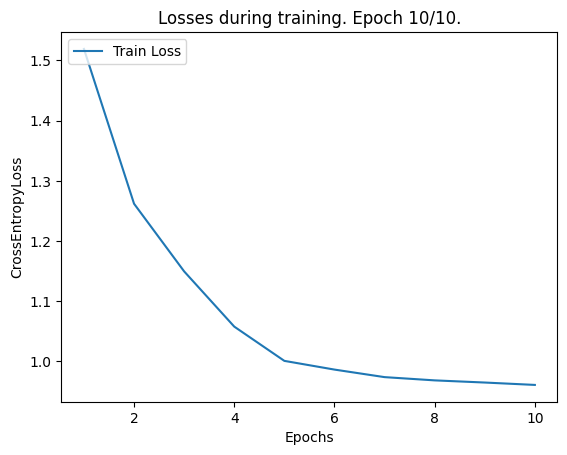

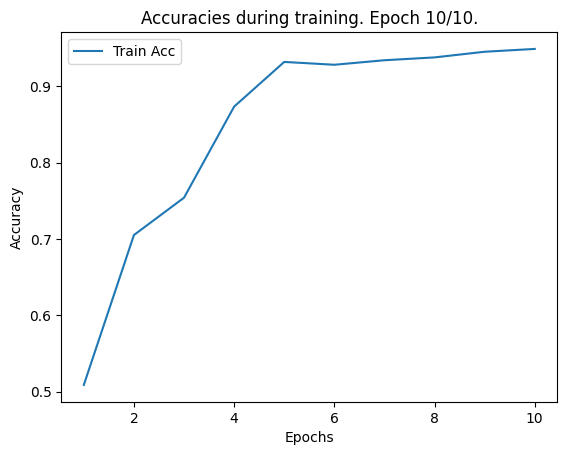

----------
Epoch Time: 0:01
*** Training Completed ***


In [21]:
model = ClassificationModel(in_channels=1, image_size=24, num_models=10, num_classes=5)
model.to(device=device)
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 10
dataloaders = dict()
dataloaders['train'] = train_dataloader
train_model(dataloaders, model, num_epochs)

torch.save(model.state_dict(), f'{local_path}weights/torch_ensemble_10k_24_classify.pt')

c:\Users\vit\.conda\envs\HICT\lib\site-packages\torch\overrides.py:1621: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)

(dot.exe:6580): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


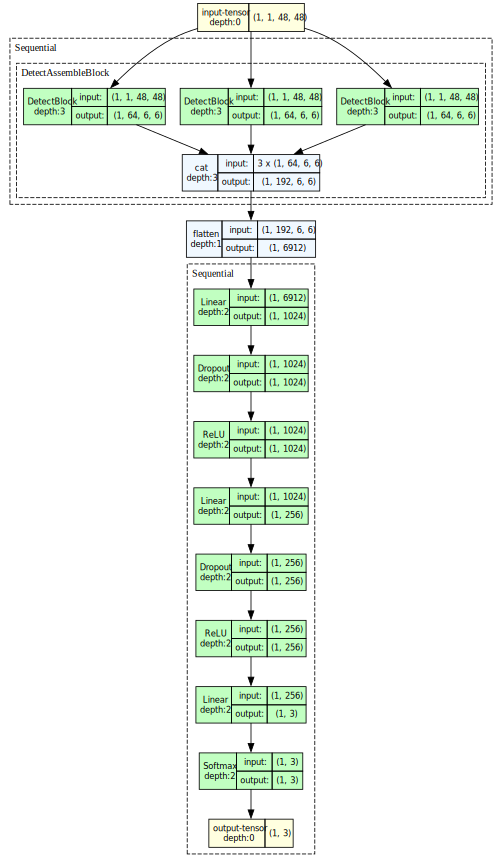

In [3]:
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('svg')

model = ClassificationModel(num_models=3, image_size=48)
batch_size = 1
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model, input_size=(batch_size, 1, 48, 48), expand_nested=True)
model_graph.visual_graph


(dot.exe:23440): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(dot.exe:22424): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


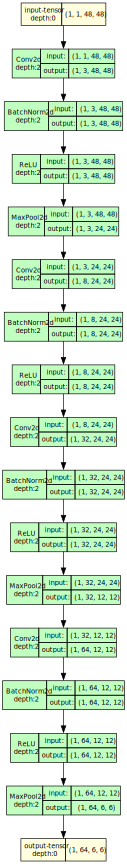

In [13]:
model_graph3 = draw_graph(model.features[0].mini_block1, input_size=(batch_size, 1, 48, 48))
model_graph3.visual_graph

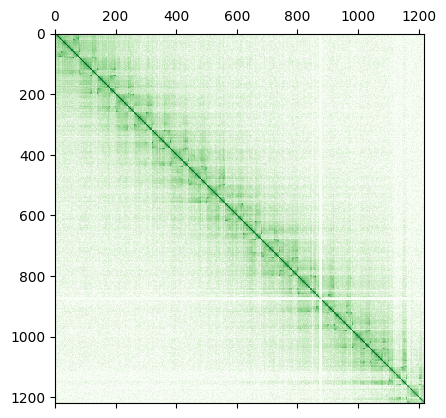

In [6]:
local_path = 'D:/Study/HICT/HICT_Patterns/'
c = cooler.Cooler(f'{local_path}/data/ZANU/ZANU_long_4DN.mcool::/resolutions/{50000}')
matrix = np.log10(c.matrix(balance=False).fetch('X') + 1)
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(matrix, cmap='Greens')